## Summary
#### [<u>Initial version</u>](https://www.kaggle.com/code/egortrushin/gr-icrgw-pytorch-lightning-baseline-unet-resnest)
- Baseline written using Pytorch Lightning
- resnest26d as encoder
- Dataset is taken from: https://www.kaggle.com/datasets/shashwatraman/contrails-images-ash-color

#### [<u>Improved version</u>](https://www.kaggle.com/code/egortrushin/gr-icrgw-pl-pipeline-improved)
- Option to change image size
- Mixed precision training (only useful with T4x2, on P100 this slows down training). This helps to use GPU memory more efficiently
- Training using 2 GPUs - with 2 GPUs we have more memory and higher speed
- Other numerous small changes

#### <u>Present version</u>
- Training with 4-folds
- LR scheduler: cosine with warmup
- Use of CSVLogger with consequent visualization of the optimization process. Since I train without internet, I am limited to *local* CSVLogger or TensorBoardLogger. Alternatively you can train with internet and WanddbLogger.
- Submission part is rewritten to make it cleaner and to allow easy work with multi-fold models

### Training part

In [1]:
import sys
sys.path.append("../input/pretrained-models-pytorch")
sys.path.append("../input/efficientnet-pytorch")
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")
sys.path.append("/kaggle/input/timm-pretrained-resnest/resnest/")
import segmentation_models_pytorch as smp

/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [2]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

In [3]:
%%writefile config.yaml

data_path: "/kaggle/input/contrails-images-ash-color"
output_dir: "models"

folds:
    n_splits: 4
    random_state: 42
train_folds: [0, 1, 2, 3]
    
seed: 42

train_bs: 48
valid_bs: 128
workers: 2

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 999
    verbose: 1

trainer:
    max_epochs: 20
    min_epochs: 20
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 2

model:
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    loss_smooth: 1.0
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
    scheduler:
        name: "cosine_with_hard_restarts_schedule_with_warmup"
        params:
            cosine_with_hard_restarts_schedule_with_warmup:
                num_warmup_steps: 350
                num_training_steps: 3150
                num_cycles: 1

Writing config.yaml


In [4]:
# Dataset

import torch
import numpy as np
import torchvision.transforms as T

class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True):

        self.df = df
        self.trn = train
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        con = np.load(str(con_path))

        img = con[..., :-1]
        label = con[..., -1]

        label = torch.tensor(label)

        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

        if self.image_size != 256:
            img = self.resize_image(img)

        img = self.normalize_image(img)

        return img.float(), label.float()

    def __len__(self):
        return len(self.df)

In [5]:
# Lightning module

import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from torchmetrics.functional import dice
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
# Actual training

import warnings

warnings.filterwarnings("ignore")

import gc
import os
import torch
import yaml
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from pytorch_lightning.loggers import CSVLogger

torch.set_float32_matmul_precision("medium")

with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)

pl.seed_everything(config["seed"])

gc.enable()

contrails = os.path.join(config["data_path"], "contrails/")
train_path = os.path.join(config["data_path"], "train_df.csv")
valid_path = os.path.join(config["data_path"], "valid_df.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

train_df["path"] = contrails + train_df["record_id"].astype(str) + ".npy"
valid_df["path"] = contrails + valid_df["record_id"].astype(str) + ".npy"

df = pd.concat([train_df, valid_df]).reset_index()

Fold = KFold(shuffle=True, **config["folds"])
for n, (trn_index, val_index) in enumerate(Fold.split(df)):
    df.loc[val_index, "kfold"] = int(n)
df["kfold"] = df["kfold"].astype(int)

for fold in config["train_folds"]:
    print(f"\n###### Fold {fold}")
    trn_df = df[df.kfold != fold].reset_index(drop=True)
    vld_df = df[df.kfold == fold].reset_index(drop=True)

    dataset_train = ContrailsDataset(trn_df, config["model"]["image_size"], train=True)
    dataset_validation = ContrailsDataset(vld_df, config["model"]["image_size"], train=False)

    data_loader_train = DataLoader(
        dataset_train,
        batch_size=config["train_bs"],
        shuffle=True,
        num_workers=config["workers"],
    )
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=config["valid_bs"],
        shuffle=False,
        num_workers=config["workers"],
    )

    checkpoint_callback = ModelCheckpoint(
        save_weights_only=True,
        monitor="val_dice",
        dirpath=config["output_dir"],
        mode="max",
        filename=f"model-f{fold}-{{val_dice:.4f}}",
        save_top_k=1,
        verbose=1,
    )

    progress_bar_callback = TQDMProgressBar(
        refresh_rate=config["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**config["early_stop"])


    trainer = pl.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback],
        logger=CSVLogger(save_dir=f'logs_f{fold}/'),
        **config["trainer"],
    )

    model = LightningModule(config["model"])

    trainer.fit(model, data_loader_train, data_loader_validation)

    del (
        dataset_train,
        dataset_validation,
        data_loader_train,
        data_loader_validation,
        model,
        trainer,
        checkpoint_callback,
        progress_bar_callback,
        early_stop_callback,
    )
    torch.cuda.empty_cache()
    gc.collect()


###### Fold 0

Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Validation: 0it [00:00, ?it/s]


Epoch: 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Validation: 0it [00:00, ?it/s]


Epoch: 3


Validation: 0it [00:00, ?it/s]


Epoch: 4


Validation: 0it [00:00, ?it/s]


Epoch: 5


Validation: 0it [00:00, ?it/s]


Epoch: 6


Validation: 0it [00:00, ?it/s]


Epoch: 7


Validation: 0it [00:00, ?it/s]


Epoch: 8


Validation: 0it [00:00, ?it/s]


Epoch: 9


Validation: 0it [00:00, ?it/s]


Epoch: 10


Validation: 0it [00:00, ?it/s]


Epoch: 11


Validation: 0it [00:00, ?it/s]


Epoch: 12


Validation: 0it [00:00, ?it/s]


Epoch: 13


Validation: 0it [00:00, ?it/s]


Epoch: 14


Validation: 0it [00:00, ?it/s]


Epoch: 15


Validation: 0it [00:00, ?it/s]


Epoch: 16


Validation: 0it [00:00, ?it/s]


Epoch: 17


Validation: 0it [00:00, ?it/s]


Epoch: 18


Validation: 0it [00:00, ?it/s]


Epoch: 19

###### Fold 1

Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Validation: 0it [00:00, ?it/s]


Epoch: 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Validation: 0it [00:00, ?it/s]


Epoch: 3


Validation: 0it [00:00, ?it/s]


Epoch: 4


Validation: 0it [00:00, ?it/s]


Epoch: 5


Validation: 0it [00:00, ?it/s]


Epoch: 6


Validation: 0it [00:00, ?it/s]


Epoch: 7


Validation: 0it [00:00, ?it/s]


Epoch: 8


Validation: 0it [00:00, ?it/s]


Epoch: 9


Validation: 0it [00:00, ?it/s]


Epoch: 10


Validation: 0it [00:00, ?it/s]


Epoch: 11


Validation: 0it [00:00, ?it/s]


Epoch: 12


Validation: 0it [00:00, ?it/s]


Epoch: 13


Validation: 0it [00:00, ?it/s]


Epoch: 14


Validation: 0it [00:00, ?it/s]


Epoch: 15


Validation: 0it [00:00, ?it/s]


Epoch: 16


Validation: 0it [00:00, ?it/s]


Epoch: 17


Validation: 0it [00:00, ?it/s]


Epoch: 18


Validation: 0it [00:00, ?it/s]


Epoch: 19

###### Fold 2

Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Validation: 0it [00:00, ?it/s]


Epoch: 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Validation: 0it [00:00, ?it/s]


Epoch: 3


Validation: 0it [00:00, ?it/s]


Epoch: 4


Validation: 0it [00:00, ?it/s]


Epoch: 5


Validation: 0it [00:00, ?it/s]


Epoch: 6


Validation: 0it [00:00, ?it/s]


Epoch: 7


Validation: 0it [00:00, ?it/s]


Epoch: 8


Validation: 0it [00:00, ?it/s]


Epoch: 9


Validation: 0it [00:00, ?it/s]


Epoch: 10


Validation: 0it [00:00, ?it/s]


Epoch: 11


Validation: 0it [00:00, ?it/s]


Epoch: 12


Validation: 0it [00:00, ?it/s]


Epoch: 13


Validation: 0it [00:00, ?it/s]


Epoch: 14


Validation: 0it [00:00, ?it/s]


Epoch: 15


Validation: 0it [00:00, ?it/s]


Epoch: 16


Validation: 0it [00:00, ?it/s]


Epoch: 17


Validation: 0it [00:00, ?it/s]


Epoch: 18


Validation: 0it [00:00, ?it/s]


Epoch: 19

###### Fold 3

Epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0


Validation: 0it [00:00, ?it/s]


Epoch: 1


Validation: 0it [00:00, ?it/s]


Epoch: 2


Validation: 0it [00:00, ?it/s]


Epoch: 3


Validation: 0it [00:00, ?it/s]


Epoch: 4


Validation: 0it [00:00, ?it/s]


Epoch: 5


Validation: 0it [00:00, ?it/s]


Epoch: 6


Validation: 0it [00:00, ?it/s]


Epoch: 7


Validation: 0it [00:00, ?it/s]


Epoch: 8


Validation: 0it [00:00, ?it/s]


Epoch: 9


Validation: 0it [00:00, ?it/s]


Epoch: 10


Validation: 0it [00:00, ?it/s]


Epoch: 11


Validation: 0it [00:00, ?it/s]


Epoch: 12


Validation: 0it [00:00, ?it/s]


Epoch: 13


Validation: 0it [00:00, ?it/s]


Epoch: 14


Validation: 0it [00:00, ?it/s]


Epoch: 15


Validation: 0it [00:00, ?it/s]


Epoch: 16


Validation: 0it [00:00, ?it/s]


Epoch: 17


Validation: 0it [00:00, ?it/s]


Epoch: 18


Validation: 0it [00:00, ?it/s]


Epoch: 19


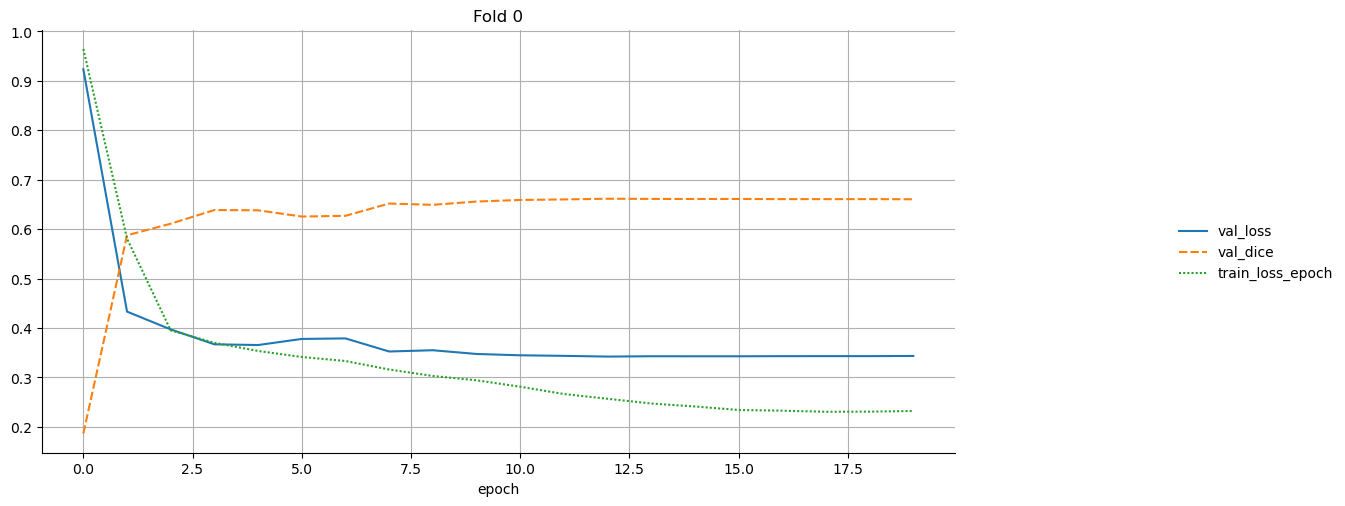

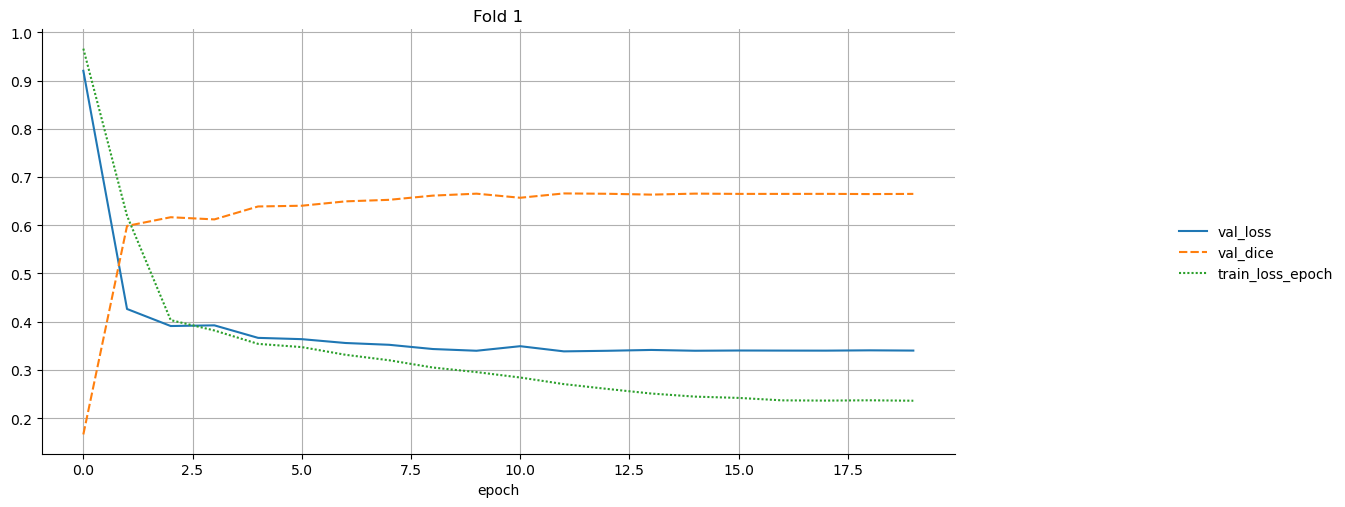

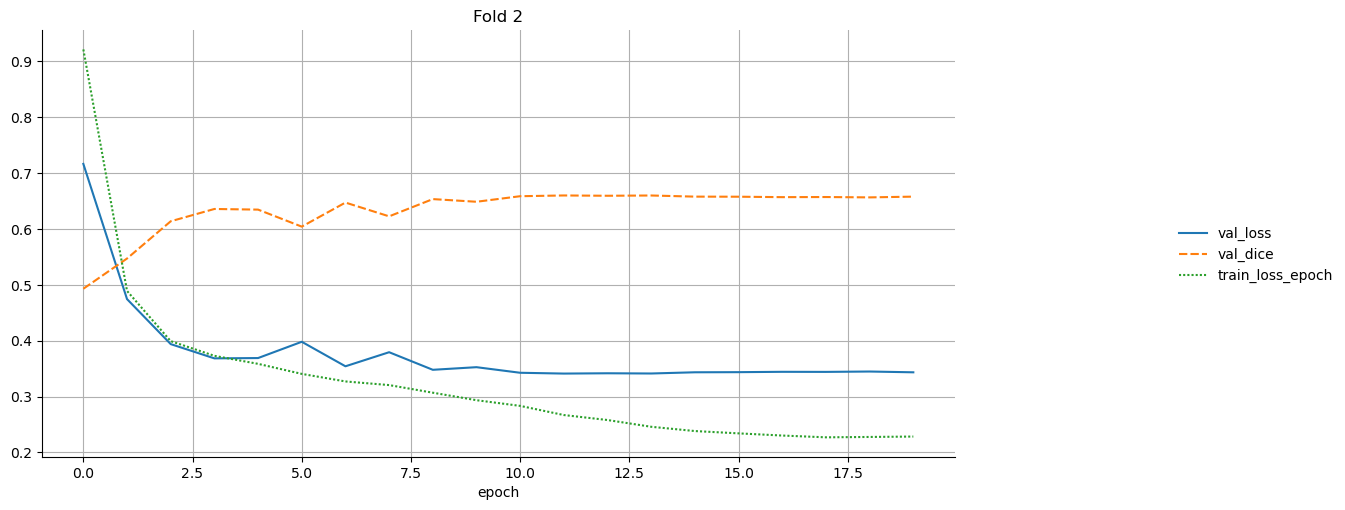

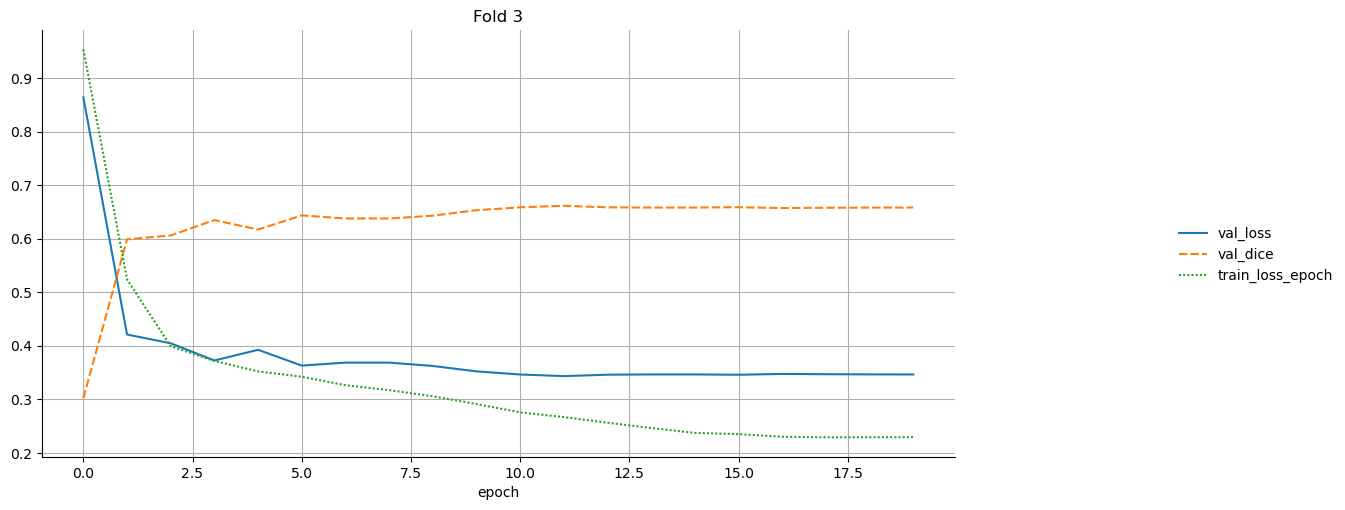

In [7]:
import seaborn as sn
import matplotlib.pyplot as plt

for fold in config["train_folds"]:
    metrics = pd.read_csv(f"/kaggle/working/logs_f{fold}/lightning_logs/version_0/metrics.csv")
    del metrics["step"]
    del metrics["lr"]
    del metrics["train_loss_step"]
    metrics.set_index("epoch", inplace=True)
    g = sn.relplot(data=metrics, kind="line")
    plt.title(f"Fold {fold}")
    plt.gcf().set_size_inches(15, 5)
    plt.grid()
    plt.show()

### Submission part

In [8]:
import warnings
warnings.filterwarnings("ignore")

import gc
import os
import glob

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import torchvision.transforms as T
import yaml

In [9]:
batch_size = 32
num_workers = 1
THR = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
data_root = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/'
submission = pd.read_csv(os.path.join(data, 'sample_submission.csv'), index_col='record_id')

In [10]:
filenames = os.listdir(data_root)
test_df = pd.DataFrame(filenames, columns=['record_id'])
test_df['path'] = data_root + test_df['record_id'].astype(str)

In [11]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True):
        
        self.df = df
        self.trn = train
        self.df_idx: pd.DataFrame = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')})
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:

            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        
        N_TIMES_BEFORE = 4

        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]

        return img
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        data = self.read_record(con_path)    
        
        img = self.get_false_color(data)
        
        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)
        
        if self.image_size != 256:
            img = self.resize_image(img)
        
        img = self.normalize_image(img)
        
        image_id = int(self.df_idx.iloc[index]['idx'])
            
        return img.float(), torch.tensor(image_id)
    
    def __len__(self):
        return len(self.df)

In [12]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [13]:
class LightningModule(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.model = smp.Unet(encoder_name=config["encoder_name"],
                              encoder_weights=None,
                              in_channels=3,
                              classes=1,
                              activation=None,
                              )

    def forward(self, batch):
        return self.model(batch)

In [14]:
MODEL_PATH = "/kaggle/working/models/"
#with open(os.path.join(MODEL_PATH, "config.yaml"), "r") as file_obj:
#    config = yaml.safe_load(file_obj)

In [15]:
test_ds = ContrailsDataset(
        test_df,
        config["model"]["image_size"],
        train = False
    )
 
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers = num_workers)

In [16]:
gc.enable()

all_preds = {}

for i, model_path in enumerate(glob.glob(MODEL_PATH + '*.ckpt')):
    print(model_path)
    model = LightningModule(config["model"]).load_from_checkpoint(model_path, config=config["model"])
    model.to(device)
    model.eval()

    model_preds = {}
    
    for _, data in enumerate(test_dl):
        images, image_id = data
    
        images = images.to(device)
        
        with torch.no_grad():
            predicted_mask = model(images[:, :, :, :])
        if config["model"]["image_size"] != 256:
            predicted_mask = torch.nn.functional.interpolate(predicted_mask, size=256, mode='bilinear')
        predicted_mask = torch.sigmoid(predicted_mask).cpu().detach().numpy()
                
        for img_num in range(0, images.shape[0]):
            current_mask = predicted_mask[img_num, :, :, :]
            current_image_id = image_id[img_num].item()
            model_preds[current_image_id] = current_mask
    all_preds[f"f{i}"] = model_preds
    
    del model    
    torch.cuda.empty_cache()
    gc.collect() 

/kaggle/working/models/model-f1-val_dice=0.6659.ckpt
/kaggle/working/models/model-f3-val_dice=0.6613.ckpt
/kaggle/working/models/model-f0-val_dice=0.6616.ckpt
/kaggle/working/models/model-f2-val_dice=0.6597.ckpt


In [17]:
for index in submission.index.tolist():
    for i in range(len(glob.glob(MODEL_PATH + '*.ckpt'))):
        if i == 0:
            predicted_mask = all_preds[f"f{i}"][index]
        else:
            predicted_mask += all_preds[f"f{i}"][index]
    predicted_mask = predicted_mask / len(glob.glob(MODEL_PATH + '*.ckpt'))
    predicted_mask_with_threshold = np.zeros((256, 256))
    predicted_mask_with_threshold[predicted_mask[0, :, :] < THR] = 0
    predicted_mask_with_threshold[predicted_mask[0, :, :] > THR] = 1
    submission.loc[int(index), 'encoded_pixels'] = list_to_string(rle_encode(predicted_mask_with_threshold))

In [18]:
submission

,encoded_pixels
record_id,
1000834164244036115,-
1002653297254493116,-


In [19]:
submission.to_csv('submission.csv')